#### Munish Kumar (14 May 2020)

##### My goal with this body of work is to determine if I can predict the number of rainfall days in a particular month. I will be using data that is measured at the Changi Climate Station. 

Note that prediction of the number of rainy days per month is, in of itself, not very helpful. This is because you will need to a priori know the other independent variables (as highlighted in the work) before using the developed models to know the actual number of rainfall days. Still, this work is interesting, if only to learn more about machine learning methods and techniques.

In this work, I will showcase the following:

1. Scraping multiple websites
2. Combining the different data sets into 1 set
3. Preprocessing i.e. descriptive statistics and deal with missing values
4. Standardize, shuffling and pickling the data
5. Different "basic" regression methods (Multilinear, Polynomial, Ridge Regression)
6. Different "advanced" regression methods (K Nearest Neighbours, Decision Tree, Support Vector Machine)
7. A.I. solution e.g. Neural Net via Tensorflow

Lets see if (5), (6) or (7) is the best solution

#### Part 1:
#### This following is a web scraper to extract open source information from data.gov.sg. The data sets are weather patterns namely rainfall, temperature and humidity data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
sns.set()

#Library for webscraping
from bs4 import BeautifulSoup
from requests.exceptions import HTTPError

from datetime import timedelta, date 
start = time.time()

Declare some global variables

In [2]:
dir_name = 'C:/Users/quant/Anaconda3/@Projects'
filename_suffix = 'csv'

I tried doing this with BeautifulSoup (BS) but I later realized the website is actually Javascript rendered, and BS does not work with this, unless I use selenium as well - a complicated solution!

Instead, use requests and pass it to a .json method. The added benefit is I dont have to iterate through "pages"

In [3]:
 def data_extract(url):
    payload = {'limit':'2000000'}

    # Persists parameters across requests
    s = requests.Session()

    # To determine success of request, and error code
    try:
        response = s.get(url)      
        # If the response was successful, no Exception will be raised 
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        # Ret
        jsonData = s.get(url, params=payload).json()
        print('Success!')

    df_tmr = pd.DataFrame(jsonData['records'])
    print ('Items in Dataframe:\n',  df_tmr.count())
    return df_tmr

Here are the websites that will be scrapped.

1. Rainfall - Monthly Total (total_rainfall): The total monthly rainfall recorded at the Changi Climate Station.
2. Rainfall - Monthly Number of Rain Days (no_of_rainy_days): The number of rain days (day with rainfall amount of 0.2mm or more) in a month recorded at the Changi Climate Station.
3. Rainfall - Monthly Maximum Daily Total (maximum_rainfall_in_a_day): The highest daily total rainfall for the month recorded at the Changi Climate Station.
***
4. Sunshine Duration- Monthly Mean Daily Duration (mean_sunshine_hrs): The monthly mean sunshine hours in a day recorded at the Changi Climate Station.
5. Wet Bulb Temperature, Hourly (wet_bulb_temperature): The hourly wet bulb temperature recorded at the Changi Climate Station
6. Surface Air Temperature - Mean Daily Minimum (temp_mean_daily_min): The monthly and annual mean daily minimum temperature recorded at the Changi Climate Station.
7. Surface Air Temperature - Monthly Absolute Extreme Minimum (temp_extremes_min): The absolute extreme minimum air temperature recorded at the Changi Climate Station.
8. Surface Air Temperature - Monthly Mean (mean_temp): The monthly mean air temperature recorded at the Changi Climate Station.
9. Surface Air Temperature - Mean Daily Maximum (temp_mean_daily_max): The monthly and annual mean daily maximum temperature recorded at the Changi Climate Station.
10. Surface Air Temperature - Monthly Absolute Extreme Maximum (max_temperature): The monthly extreme maximum air temperature recorded at the Changi Climate Station.
***
11. Relative Humidity - Monthly Absolute Extreme Minimum (rh_extremes_minimum): The absolute extreme minimum relative humidity for the month recorded at the Changi Climate Station.
12. Relative Humidity - Monthly Mean (mean_rh): The monthly mean relative humidity recorded at the Changi Climate Station.
13. Relative Humidity - Annual Means (rh_mean_daily): The annual average values for the daily mean relative humidity, daily maximum relative humidity and daily minimum relative humidity recorded at the Changi Climate Station.

In [4]:
# extract data directly with json, drop everything in the hyperlink 
# after /view and replace with /data
urls_ori = {
    # Rainfall data
    'tot_rain_mth': 'https://data.gov.sg/dataset/5942f8bd-4240-4f68-acd2-a5a276958237/resource/778814b8-1b96-404b-9ac9-68d6c00e637b/data',
    'no_days_rain_mth': 'https://data.gov.sg/dataset/rainfall-monthly-number-of-rain-days/resource/8b94f596-91fd-4545-bf9e-7a426493b674/data',
    'max_rain_mth': 'https://data.gov.sg/dataset/rainfall-monthly-maximum-daily-total/resource/df4d391e-6950-4fc6-80cd-c9b9ef6354fe/data',
    # Temperature Data
    'mean_sun_dur_mth': 'https://data.gov.sg/dataset/sunshine-duration-monthly-mean-daily-duration/resource/0230819f-1c83-4980-b738-56136d6dc300/data',
    'wet_bulb_hr': 'https://data.gov.sg/dataset/wet-bulb-temperature-hourly/resource/0195dc7a-2f49-4107-ac7c-3112ca4a09a8/data',
    'min_air_temp_day': 'https://data.gov.sg/dataset/surface-air-temperature-mean-daily-minimum/resource/ad0d8a97-9321-42e9-ac6f-46bf12845d44/data',
    'min_air_temp_mth': 'https://data.gov.sg/dataset/surface-air-temperature-monthly-absolute-extreme-minimum/resource/0c5b9752-2488-46cc-ae1c-42318d0f8865/data',
    'mean_air_temp_mth': 'https://data.gov.sg/dataset/surface-air-temperature-monthly-mean/resource/07654ce7-f97f-49c9-81c6-bd41beba4e96/data',
    'max_air_temp_day': 'https://data.gov.sg/dataset/surface-air-temperature-mean-daily-maximum/resource/c7a7d2fd-9d32-4508-92ef-d1019e030a2f/data',
    'max_air_temp_mth': 'https://data.gov.sg/dataset/air-temperature-absolute-extremes-maximum/resource/96e66346-68bb-4ca9-b001-58bbf39e36a7/data',
    # Humidity Data
    'min_hum_mth': 'https://data.gov.sg/dataset/relative-humidity-monthly-absolute-extreme-minimum/resource/585c24a5-76cd-4c48-9341-9223de5adc1d/data',
    'mean_hum_mth': 'https://data.gov.sg/dataset/relative-humidity-monthly-mean/resource/4631174f-9858-463d-8a88-f3cb21588c67/data',
    'mean_hum_yr': 'https://data.gov.sg/dataset/relative-humidity-annual-mean/resource/77b9059f-cc9a-4f4f-a495-9c268945191b/data' 
}

df={}
urls = list(urls_ori.values())
for i in range(len(urls)):
    print("------------------------------------")
    print("Name of Dataframe:", i)
    df[str(i)] = data_extract(urls[i])
    df[i] = pd.DataFrame.from_dict(df[str(i)])
countr = i # hold count of total number of files read

------------------------------------
Name of Dataframe: 0
Success!
Items in Dataframe:
 _id               459
total_rainfall    459
month             459
dtype: int64
------------------------------------
Name of Dataframe: 1
Success!
Items in Dataframe:
 _id                 459
no_of_rainy_days    459
month               459
dtype: int64
------------------------------------
Name of Dataframe: 2
Success!
Items in Dataframe:
 maximum_rainfall_in_a_day    459
_id                          459
month                        459
dtype: int64
------------------------------------
Name of Dataframe: 3
Success!
Items in Dataframe:
 mean_sunshine_hrs    459
_id                  459
month                459
dtype: int64
------------------------------------
Name of Dataframe: 4
Success!
Items in Dataframe:
 wbt_date                295030
wet_bulb_temperature    295030
_id                     295030
wbt_time                295030
dtype: int64
------------------------------------
Name of Dataframe: 5
S

Create a series of checkpoint files; also combine the files into a master file that we can then later analyse.

PS: I will admit, this is a rather long winded way of doing this, as really, on every one of the URLs, you can just download the sheet. However, the objective of this is NOT just the data, but rather the process of scraping for the data.

In [5]:
def combine_multiple():
    filenames = glob.glob("*." + filename_suffix, recursive=True)
    olddf=pd.DataFrame()
    for num, f in enumerate(filenames,start=1):
        if len(f)>0:
            df=pd.read_csv(f)
            olddf=pd.concat([olddf,df], ignore_index=True).reset_index(drop=True)
    olddf.to_csv('1_Weather_Raw.csv')    
    print ("Final File Extract Produced")
    return

#Each csv file will be output and names as per the dict keys; the files
#will later be combined to 1 master file
base_filename = list(urls_ori.keys())
for i in range(countr+1): 
    csvs_sht = os.path.join(dir_name, base_filename[i] + "." + filename_suffix)    
    df[i].to_csv (csvs_sht, index = False, header=True)

combine_multiple()

Final File Extract Produced


Checking the properties of the extracted data frame, some columns need to be dropped and others need to be recast before further clean up can be done

In [6]:
df_tmr=pd.read_csv('@Weather_Final.csv')
# Drop column [0], cast to float if needed and convert to datetime
df_tmr = df_tmr.drop('_id', axis = 1)
df_tmr = df_tmr.loc[:, ~df_tmr.columns.str.contains('^Unnamed')]
#df_tmr['total_rainfall'] = df_tmr['total_rainfall'].astype(float)
df_tmr['month'] = pd.to_datetime(df_tmr['month'], 
                                 infer_datetime_format=True
                                )
df_tmr['wbt_date'] = pd.to_datetime(df_tmr['wbt_date'], 
                                 infer_datetime_format=True
                                )

print("Column labels in Dataframe:\n", df_tmr.columns.values)
df_tmr.info()

C:\Users\quant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Column labels in Dataframe:
 ['temp_mean_daily_max' 'month' 'max_temperature'
 'maximum_rainfall_in_a_day' 'mean_temp' 'mean_rh' 'rh_mean_daily'
 'rh_mean_daily_minimum' 'rh_means_daily_maximum' 'year'
 'mean_sunshine_hrs' 'temp_mean_daily_min' 'temp_extremes_min'
 'rh_extremes_minimum' 'no_of_rainy_days' 'total_rainfall' 'wbt_date'
 'wet_bulb_temperature' 'wbt_time']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299867 entries, 0 to 299866
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   temp_mean_daily_max        459 non-null     float64       
 1   month                      4799 non-null    datetime64[ns]
 2   max_temperature            459 non-null     float64       
 3   maximum_rainfall_in_a_day  459 non-null     float64       
 4   mean_temp                  459 non-null     float64       
 5   mean_rh                    459 non-null     float64       
 6   r

Plot the Data to verify that everything is good. For convenience, will use subplots to do this so we can see the data holistically

Text(0, 0.5, 'Rainfall (mm)')

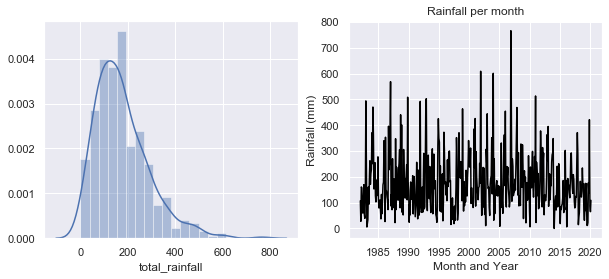

In [7]:
fig, axs = plt.subplots(ncols=2)
fig.set_figwidth(10)

sns.distplot(df_tmr['total_rainfall'], ax=axs[0])
plt.title('Histogram - Data Distribution')
# Set x-axis label
plt.xlabel('Total Rainfall (mm)')
# Set y-axis label
plt.ylabel('Frequency')

sns.lineplot(x=df_tmr['month'], y=df_tmr['total_rainfall'], 
             color='black', ax=axs[1])
plt.title('Rainfall per month')
plt.xlabel('Month and Year')
plt.ylabel('Rainfall (mm)')

End of Web-Scraping phase

In [8]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 46.68236994743347 seconds
